In [2]:
import os
import time
from collections import deque
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

import utilities

Features to add:
- add item_category, shop_id, and item_id as features
- encode these categorical vars: mean encode - HOW?
    - most successfull one in the homework was expanding mean scheme. - suggests I need lagged features too

- create a feature that bins shops into groups based on net income
    - perhaps net income by category of item
- create feature that bins shops into groups based on seasonal pattern (spectral biclustering?)
- similarly create a feature that groups products based on seasonal pattern
- need to add date indicators:
    * perhaps group months into high holiday/low holiday count
    * perhaps number of days in month
    * number of weekend days vs week days
- create features based on lagged behavior
    * rolling windows sum/variance (last 3 mos, last 6 months, last year)
    * can do this for each item, or can use this as an encoding of shop, and category ids


# TODO:
    - add encoding to the pipeline
    - item/shop popularity is probably very seasonal - time matters; this needs to be reflected in features
    - transform to log(1+sales)??

In [3]:
sales = utilities.load_and_preprocess()

# Pre processing

In [4]:
agg_sales = utilities.aggregate_monthly(sales)
piv_agg_sales = agg_sales.set_index(['Month', 'shop_id', 'item_id']).item_cnt_month.unstack(level=0).fillna(0)

In [73]:
months = list(agg_sales.Month.unique())

In [74]:
month = months[0]

In [75]:
month_data = agg_sales[agg_sales.Month == month]

In [76]:
shops = month_data.shop_id.unique()

In [77]:
item_ids = month_data.item_id.unique()

In [70]:
month_data

,Month,shop_id,item_id,item_cnt_month,item_price
0,2013-01,0,32,6.0,221.0
1,2013-01,0,33,3.0,347.0
2,2013-01,0,35,1.0,247.0
3,2013-01,0,43,1.0,221.0
4,2013-01,0,51,2.0,128.5
...,...,...,...,...,...
63219,2013-01,59,22092,2.0,109.0
63220,2013-01,59,22130,2.0,349.0
63221,2013-01,59,22134,2.0,399.0
63222,2013-01,59,22151,2.0,399.0


In [68]:
from itertools import product

In [69]:
product(shops, item_ids, [])

In [5]:
stacked = piv_agg_sales.stack()

In [6]:
stacked[stacked !=0].describe()

count    1.606541e+06
mean     2.270845e+00
std      8.656355e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
dtype: float64

In [7]:
stacked.sort_values()

shop_id  item_id  Month  
12       8023     2013-11     -22.0
         1590     2013-01     -13.0
         1593     2013-01      -6.0
         11367    2014-08      -5.0
         3732     2013-11      -4.0
                              ...  
55       3730     2015-04    1242.0
31       20949    2013-12    1305.0
55       9249     2015-09    1644.0
12       9248     2015-09    1644.0
         11373    2015-10    2253.0
Length: 14420216, dtype: float64

In [8]:
preprocessed_data = np.clip(piv_agg_sales, 0, 20)

In [9]:
preprocessed_data.stack().sort_values()

shop_id  item_id  Month  
0        30       2013-01     0.0
41       17063    2015-02     0.0
                  2015-03     0.0
                  2015-04     0.0
                  2015-05     0.0
                             ... 
25       4084     2015-06    20.0
14       2308     2015-06    20.0
22       3329     2014-02    20.0
9        15284    2014-10    20.0
51       2814     2014-04    20.0
Length: 14420216, dtype: float64

# Feature generation

In [10]:
preprocessed_data.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     20.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

In [11]:
target_encode_shops = preprocessed_data.groupby(level=0).transform('sum')
target_encode_items = preprocessed_data.groupby(level=1).transform('sum')

In [12]:
%%time
half_lifes = [1,2,3,6,9,12]
sales_ewms_mean = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
sales_ewms_std = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).std() for tau in half_lifes}
items_ewms = {tau:target_encode_items.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
shops_ewms = {tau:target_encode_shops.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}

Wall time: 55.4 s


In [13]:
prices = agg_sales.set_index(['Month', 'shop_id', 'item_id']).item_price.unstack(level=0).fillna(0)

shop_monthly_income = (prices*piv_agg_sales).groupby(level=0).transform('sum')
item_monthly_income = (prices*piv_agg_sales).groupby(level=1).transform('sum')

In [14]:
%%time
items_income_ewms = {tau:item_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
shops_income_ewms = {tau:shop_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}

Wall time: 26.5 s


In [15]:
all_months = preprocessed_data.columns.tolist()
full_data_months = all_months[11:-1]

In [16]:
sales_mean_features = {f'sales_ewms_mean_{tau}': sales_ewms_mean[tau] for tau in half_lifes}
sales_std_features = {f'sales_ewms_std_{tau}': sales_ewms_std[tau] for tau in half_lifes}
items_features = {f'items_ewms_{tau}': items_ewms[tau] for tau in half_lifes}
shops_features = {f'shops_ewms_{tau}': shops_ewms[tau] for tau in half_lifes}
items_incom_features = {f'items_income_ewms_{tau}': items_income_ewms[tau] for tau in half_lifes}
shops_incom_features = {f'shops_income_ewms_{tau}': shops_income_ewms[tau] for tau in half_lifes}

features_dict = {**sales_mean_features, **sales_std_features, **items_features, **shops_features, **items_incom_features, **shops_incom_features}

#### Define objective

In [17]:
# Note that I use raw-data for objective 
objectives = piv_agg_sales.shift(-1, axis=1)

In [18]:
np.argmax(preprocessed_data.columns == (full_data_months[0]))

11

In [19]:
def get_single_month_XY(month_, drop_cols = None, num_lagged_values=0):
    cols = [df[month_].rename(name) for (name, df) in features_dict.items()]
    X = pd.concat(cols, axis=1)
    Y = objectives[month_]
    
    if num_lagged_values > 0:
        idx = np.argmax(preprocessed_data.columns == month_)
        assert idx >= num_lagged_values, "do not have enough columns for desired lags"
        lagged_vals = preprocessed_data.iloc[:,idx-num_lagged_values:idx]
        lagged_vals.columns = [f'lag{lag}' for lag in list(range(1,num_lagged_values+1))[::-1]]
        X = pd.concat([X,lagged_vals], axis=1)
    
    # might turn this into separate function to pass into here
    X['month'] = month_.month
    X['season'] = X.month.map({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2, 11:3, 12:3})
    
    if drop_cols is not None:
        X = X.drop(drop_cols, axis=1)
    
    return X,Y

In [20]:
tempx, tempy = get_single_month_XY(all_months[-1], num_lagged_values=12)

In [21]:
tempx.head()

sales_ewms_mean_1  sales_ewms_mean_2  sales_ewms_mean_3  \
shop_id item_id                                                            
0       30            2.328306e-09           0.000089           0.002539   
        31            1.280569e-09           0.000049           0.001397   
        32            1.513399e-09           0.000064           0.001874   
        33            5.238689e-10           0.000023           0.000683   
        35            1.688022e-09           0.000066           0.001878   

                 sales_ewms_mean_6  sales_ewms_mean_9  sales_ewms_mean_12  \
shop_id item_id                                                             
0       30                0.055208           0.136002            0.205637   
        31                0.030364           0.074801            0.113101   
        32                0.042359           0.105777            0.161047   
        33                0.015659           0.039288            0.059960   
        35                0.041105           0.101497            0.153651   

                 sales_ewms_std_1  sales_ewms_std_2  sales_ewms_std_3  \
shop_id item_id                                                         
0       30               0.000264          0.046454          0.239550   
        31               0.000145          0.025549          0.131752   
        32               0.000144          0.026016          0.135807   
        33               0.000049          0.009104          0.048122   
        35               0.000185          0.032576          0.168023   

                 sales_ewms_std_6  ...  lag8  lag7  lag6  lag5  lag4  lag3  \
shop_id item_id                    ...                                       
0       30               1.082319  ...   0.0   0.0   0.0   0.0   0.0   0.0   
        31               0.595275  ...   0.0   0.0   0.0   0.0   0.0   0.0   
        32               0.621241  ...   0.0   0.0   0.0   0.0   0.0   0.0   
        33               0.222969  ...   0.0   0.0   0.0   0.0   0.0   0.0   
        35               0.759210  ...   0.0   0.0   0.0   0.0   0.0   0.0   

                 lag2  lag1  month  season  
shop_id item_id                             
0       30        0.0   0.0     10       2  
        31        0.0   0.0     10       2  
        32        0.0   0.0     10       2  
        33        0.0   0.0     10       2  
        35        0.0   0.0     10       2  

[5 rows x 50 columns]

features_dicttting and CV

In [22]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    start_time = time.time()
    fitted_model = model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model.predict(x_val)
    else:
        y_val_pred = None
        
    return fitted_model, y_train_pred, y_val_pred, fit_time

In [23]:
def plot_feature_importances(mod, col_names=None, figsize=(6,10)):
    plt.figure(figsize=figsize)
    importances = mod.feature_importances_
    if type(importances) == pd.Series:
        importances.sort_values().plot(kind='barh')
    elif col_names is not None:
        pd.Series(importances, index=col_names).sort_values().plot(kind='barh')
    else:
        print('dont have col names')

In [24]:
# using the 0th month is not good, because december behavior is very non-predicitve of jan behavior
DROP_COLS = []
X_train,Y_train = get_single_month_XY(full_data_months[4], drop_cols=DROP_COLS, num_lagged_values=12)
X_val,Y_val = get_single_month_XY(full_data_months[5], drop_cols=DROP_COLS, num_lagged_values=12)

In [25]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(48.10434937477112, 1.6312150500101998, 1.8597492315982111)

In [26]:
elapsed, mean_squared_error(Y_train, np.clip(ytpred,0,20)), mean_squared_error(Y_val, np.clip(yvpred, 0 ,20))

(48.10434937477112, 4.384548354061024, 5.1290065019500926)

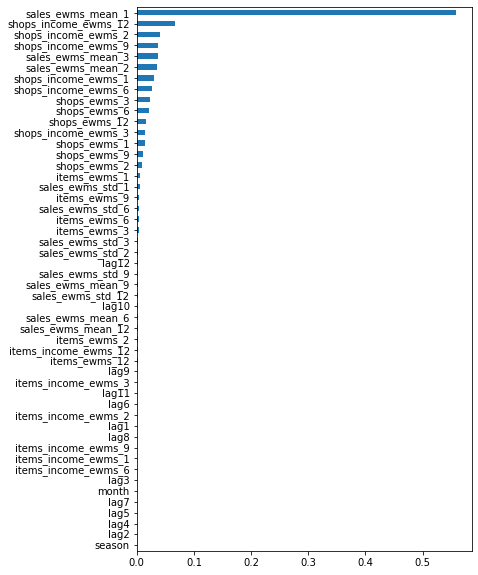

In [92]:
plot_feature_importances(fitted, col_names=X_train.columns)

In [27]:
mod = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(147.45052027702332, 1.4690477805385977, 1.7073934546390999)

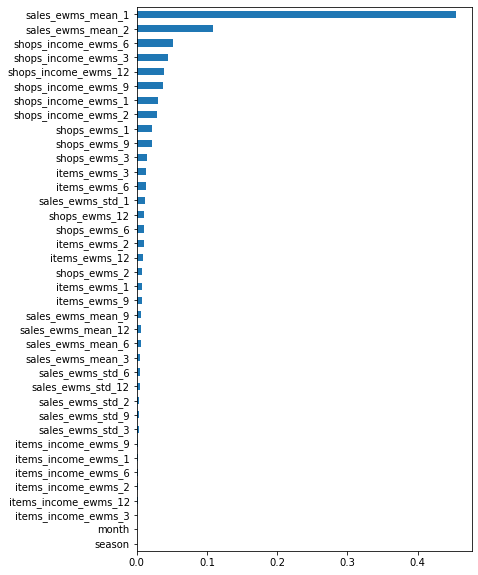

In [28]:
plot_feature_importances(fitted, X_train.columns)

In [33]:
import xgboost as xgb

class xgb_model:
    def __init__(self, num_boost_round, **params):
        self.params = {
            'max_depth':6,
            'min_child_weight': 1,
            'eta':.3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'lambda':1,
            'gamma':0.1,
            'objective':'reg:squarederror',
            # leave nthread default - detects all cores automatically
        }
        self.params.update(params)
        self.fitted_model = None
        self.num_boost_round = num_boost_round
       
    def fit(self, X, Y):
        dm_train = xgb.DMatrix(X,Y)
        self.fitted_model = xgb.train(self.params, dtrain=dm_train, num_boost_round=self.num_boost_round)
        return self
    
    def predict(self, X):
        assert self.fitted_model is not None, 'Must fit first'
        dm = xgb.DMatrix(X)
        return self.fitted_model.predict(dm)
    
    @property
    def feature_importances_(self):
        return pd.Series(self.fitted_model.get_score(importance_type='weight'))

In [93]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(26.49715518951416, 1.2696821627439183, 1.7036145223038577)

In [94]:
mod = xgb_model(num_boost_round=100, max_depth=20, eta=0.1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(66.52813577651978, 1.1196057062632119, 1.694079261009782)

In [34]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(22.517793655395508, 1.2732372589390728, 1.800842958242524)

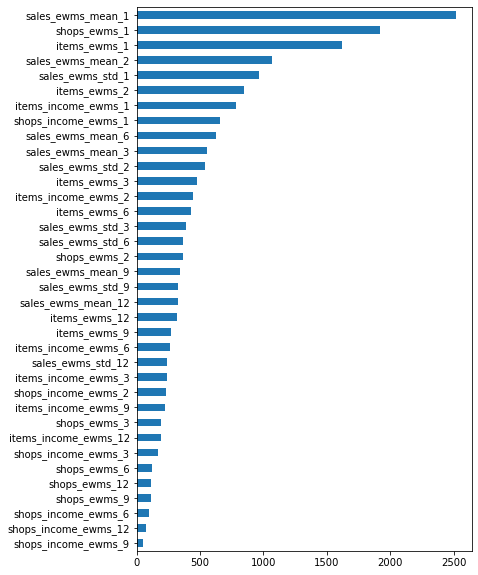

In [35]:
plot_feature_importances(fitted)

In [36]:
mod = xgb_model(num_boost_round=50, max_depth=10, eta=0.2)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(11.595996141433716, 1.2769410530095493, 1.6838278200251264)

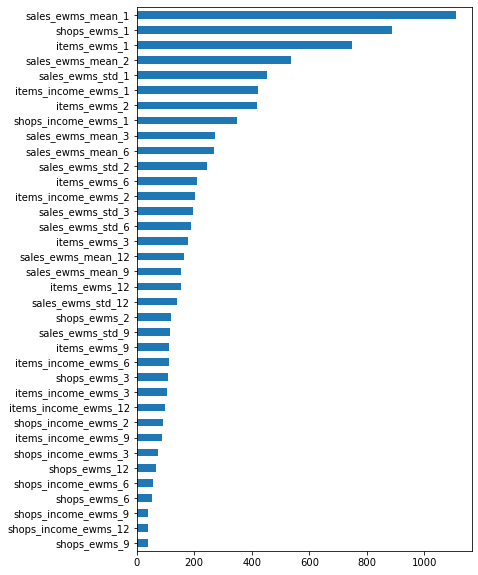

In [37]:
plot_feature_importances(fitted)

In [40]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.2)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(24.04870319366455, 1.221521536648759, 1.6907810345000311)

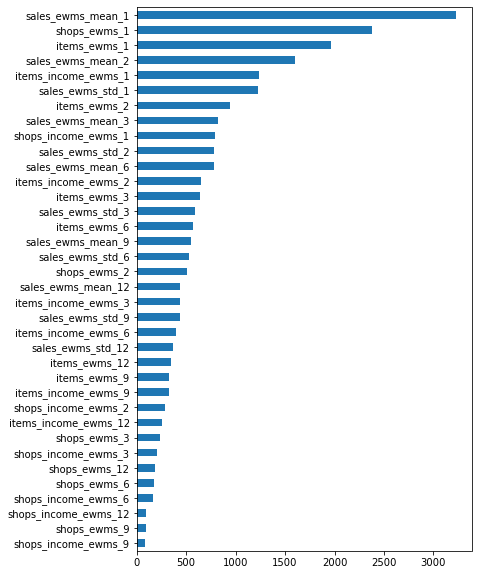

In [41]:
plot_feature_importances(fitted)

In [1]:
NUM_LAGGED_VALUES = 24
DROP_COLUMNS = list(features_dict.keys()) + ['month', 'season']

def rolling_cross_validation(model, data_months_list, post_process_preds = None, validate_months_num=None, num_stack_months=1, fit_final=False):
    if post_process_preds is None:
        post_process_preds = lambda x: x
        
    Xs_deque = deque()
    Ys_deque = deque()
    
    for month in data_months_list[:num_stack_months]:
        X_, Y_ = get_single_month_XY(month, drop_cols=DROP_COLUMNS, num_lagged_values=NUM_LAGGED_VALUES)
        Xs_deque.append(X_)
        Ys_deque.append(Y_)
        
           
    if validate_months_num is None:
        validate_months_num = len(data_months_list) - num_stack_months
    else:
        validate_months_num = min(validate_months_num, len(data_months_list) - num_stack_months)
        
    
    fitted_models = {}
    in_sample_scores = {}
    oos_scores = {}
    loop_times = []
    
    for month in data_months_list[num_stack_months: num_stack_months + validate_months_num]:
        print(f'Working on: {month}')
        loop_start = time.time()
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        
        X_val, Y_val = get_single_month_XY(month, drop_cols=DROP_COLUMNS, num_lagged_values=NUM_LAGGED_VALUES)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models[month] = fitted
        print(f'fit time: {elapsed_time}')
        
        in_sample_scores[month] = mean_squared_error(Y_train, post_process_preds(ytrain_pred))
        oos_scores[month] = mean_squared_error(Y_val, post_process_preds(yval_pred))
        
        Xs_deque.popleft()
        Ys_deque.popleft()
        
        Xs_deque.append(X_val)
        Ys_deque.append(Y_val)
        
        loop_end = time.time()
        loop_times.append(loop_end - loop_start)
    
    if fit_final:
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models['FINAL'] = fitted
        in_sample_scores['FINAL'] = mean_squared_error(Y_train, post_process_preds(ytrain_pred))
    
    
    return fitted_models, in_sample_scores, oos_scores, loop_times

NameError: name 'features_dict' is not defined

In [139]:
mod = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=5)
fitted_models, isscores, osscores, times = rolling_cross_validation(mod, full_data_months[20:], num_stack_months=1, fit_final=True)

Working on: 2015-09
fit time: 35.86212468147278


In [140]:
fitted_models

{Period('2015-09', 'M'): RandomForestRegressor(max_depth=10, n_jobs=5),
 'FINAL': RandomForestRegressor(max_depth=10, n_jobs=5)}

In [141]:
pd.Series(isscores)

2015-09     3.320216
FINAL      12.366350
dtype: float64

In [142]:
pd.Series(osscores)

2015-09    24.195836
Freq: M, dtype: float64

In [147]:
temp = pd.read_csv('2020_08_26_month_stacked_xgb_with_ewms_more_inds_V3.csv', index_col='ID')

In [152]:
temp.item_cnt_month.sort_values()

ID
122771     -24.103754
122406     -10.609228
46990       -6.697152
122444      -4.570059
210190      -4.557869
             ...     
56560      330.506130
102460     389.925540
46360      408.432560
41260      707.361300
37296     1765.688700
Name: item_cnt_month, Length: 214200, dtype: float64

#### THIS CLIPPING MEANS THE DIFFERENCE BETWEEN A 6 and 1 score solution.

In [155]:
np.clip(temp, 0,20).to_csv('2020_08_26_month_stacked_xgb_with_ewms_more_inds_V3_clipped.csv')

In [104]:
#mod = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=5)
mod = xgb_model(num_boost_round=500, max_depth=20, eta=0.3, gpu_id=0, tree_method='gpu_hist')
fitted_models, isscores, osscores, times = rolling_cross_validation(mod, full_data_months[-20:], num_stack_months=18, fit_final=True)

Working on: 2015-08
fit time: 577.5070893764496
Working on: 2015-09
fit time: 553.4928925037384


In [105]:
fitted_models

{Period('2015-08', 'M'): <__main__.xgb_model at 0x13fb98d7438>,
 Period('2015-09', 'M'): <__main__.xgb_model at 0x13fb98d7438>,
 'FINAL': <__main__.xgb_model at 0x13fb98d7438>}

In [106]:
pd.Series(isscores)

2015-08    1.520218
2015-09    1.493343
FINAL      1.424009
dtype: float64

In [107]:
pd.Series(osscores)

2015-08    19.841497
2015-09    14.006442
Freq: M, dtype: float64

In [60]:
#mod = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=5)
mod = xgb_model(num_boost_round=500, max_depth=10, eta=0.3, gpu_id=0, tree_method='gpu_hist')
fitted_models, isscores, osscores, times = rolling_cross_validation(mod, full_data_months[-20:], num_stack_months=18, fit_final=True)

Working on: 2015-08
fit time: 122.16142749786377
Working on: 2015-09
fit time: 120.46891212463379


In [61]:
fitted_models

{Period('2015-08', 'M'): <__main__.xgb_model at 0x13f8065efd0>,
 Period('2015-09', 'M'): <__main__.xgb_model at 0x13f8065efd0>,
 'FINAL': <__main__.xgb_model at 0x13f8065efd0>}

In [62]:
pd.Series(isscores)

2015-08    1.660575
2015-09    1.632676
FINAL      1.559067
dtype: float64

In [63]:
pd.Series(osscores)

2015-08    19.428612
2015-09    12.160473
Freq: M, dtype: float64

In [53]:
fitted_models

{Period('2015-08', 'M'): <__main__.xgb_model at 0x13f8b867198>,
 Period('2015-09', 'M'): <__main__.xgb_model at 0x13f8b867198>,
 'FINAL': <__main__.xgb_model at 0x13f8b867198>}

In [54]:
pd.Series(isscores)

2015-08    1.684703
2015-09    1.653207
FINAL      1.580408
dtype: float64

In [55]:
pd.Series(osscores)

2015-08    19.430249
2015-09    14.308523
Freq: M, dtype: float64

In [45]:
fitted_models

{Period('2015-08', 'M'): <__main__.xgb_model at 0x13f8cf4e710>,
 Period('2015-09', 'M'): <__main__.xgb_model at 0x13f8cf4e710>,
 'FINAL': <__main__.xgb_model at 0x13f8cf4e710>}

In [46]:
pd.Series(isscores)

2015-08    2.024273
2015-09    2.005750
FINAL      1.936844
dtype: float64

In [47]:
pd.Series(osscores)

2015-08    19.618823
2015-09    14.017673
Freq: M, dtype: float64

In [84]:
fitted_models

{Period('2015-08', 'M'): <__main__.xgb_model at 0x2d18bbb3f28>,
 Period('2015-09', 'M'): <__main__.xgb_model at 0x2d18bbb3f28>,
 'FINAL': <__main__.xgb_model at 0x2d18bbb3f28>}

In [85]:
pd.Series(isscores)

2015-08    2.713818
2015-09    3.066222
FINAL      3.059186
dtype: float64

In [86]:
pd.Series(osscores)

2015-08    21.253366
2015-09    13.252615
Freq: M, dtype: float64

In [56]:
X,Y = get_single_month_XY(all_months[-1])

In [57]:
predictions = fitted_models['FINAL'].predict(X)

In [58]:
predictions = pd.DataFrame({'item_cnt_month':predictions}, index=X.index)

In [59]:
utilities.merge_pred_with_test(predictions).to_csv('2020_08_26_month_stacked_xgb_with_ewms_more_inds_V3.csv')

# Analysis

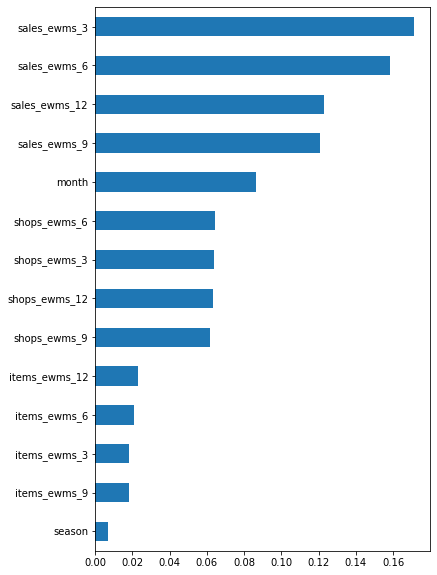

In [106]:
plot_feature_importances(fitted_models['FINAL'], X_train.columns)

Other code

TODO:
- understand test set vis a vis my test sets
- recreate data set as they do
- include item category - and mean encode that to
- more target encodings
- use shops info somehow? - where are they, other geogrphically relevant stuff?
- target encode month with number of items sold
- target encode month with total revenue
- I need to somehow show decrease in sales trend (perhaps I can remove it)
    - I could also simply remove december data; they are clear outliers
- feature: nununique items sold that month

In [27]:
sales = utilities.load_and_preprocess()

In [36]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month
0,2013-01-02,0,59,22154,999.00,1.0,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015-10
2935845,2015-10-09,33,25,7460,299.00,1.0,2015-10
2935846,2015-10-14,33,25,7459,349.00,1.0,2015-10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015-10


In [50]:
sales.groupby('Month').count()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
Month,,,,,,
2013-01,115690,115690,115690,115690,115690,115690
2013-02,108613,108613,108613,108613,108613,108613
2013-03,121347,121347,121347,121347,121347,121347
2013-04,94109,94109,94109,94109,94109,94109
2013-05,91759,91759,91759,91759,91759,91759
2013-06,100403,100403,100403,100403,100403,100403
2013-07,100548,100548,100548,100548,100548,100548
2013-08,104772,104772,104772,104772,104772,104772
2013-09,96137,96137,96137,96137,96137,96137


In [52]:
sales.groupby('Month').item_id.nunique()

Month
2013-01    8115
2013-02    8168
2013-03    8302
2013-04    8145
2013-05    8339
2013-06    8478
2013-07    8405
2013-08    8031
2013-09    7876
2013-10    8039
2013-11    8089
2013-12    8474
2014-01    7551
2014-02    7134
2014-03    7142
2014-04    6774
2014-05    6685
2014-06    6681
2014-07    6611
2014-08    6363
2014-09    6071
2014-10    6334
2014-11    6322
2014-12    6605
2015-01    6139
2015-02    6053
2015-03    6082
2015-04    5476
2015-05    5283
2015-06    5216
2015-07    5323
2015-08    5108
2015-09    5085
2015-10    5413
Freq: M, Name: item_id, dtype: int64

In [56]:
sales[sales.date_block_num == 0].groupby('shop_id').item_id.nunique()

shop_id
0     2385
1     1535
2      728
3      544
4     1062
6     1865
7     1271
8      986
10     631
12     457
13     755
14    1047
15    1230
16    1667
18    1430
19    1528
21     991
22     845
23    1168
24    1036
25    3137
26    1294
27    2138
28    2649
29    1395
30    1675
31    3386
32     843
35    1202
37    1436
38     915
41    1036
42    1851
43     936
44    1111
45     955
46    1589
47    1077
50    1577
51    1533
52    1086
53    1113
54    3307
56    1764
59    1058
Name: item_id, dtype: int64

In [31]:
test = pd.read_csv(r'data/test.csv', index_col='ID')

In [32]:
test

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


In [40]:
test.groupby('shop_id').item_id.count()

shop_id
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
59    5100
Name: item_id, dtype: int64

In [42]:
Y_train.shape

(424124,)

In [45]:
len(sales.item_id.unique())

21807

In [48]:
items = pd.read_csv(r'data/items.csv', index_col='item_id')

In [49]:
items

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40
...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",31
22166,Язык запросов 1С:Предприятия [Цифровая версия],54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49
